In [2]:
# https://brian2.readthedocs.io/en/stable/resources/tutorials/3-intro-to-brian-simulations.html
from brian2 import *

Text(0, 0.5, 'Firing rate (sp/s)')

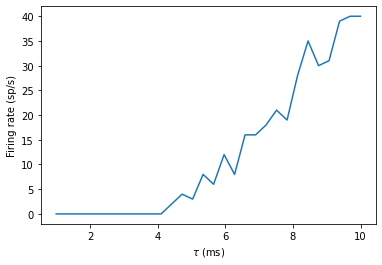

In [3]:
# Multiple runs
# How does the firing rate of a leaky integrate-and-fire neuron 
# driven by Poisson spiking neurons change depending on its membrane time constant?
start_scope()

num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms # Range of the membrane time constant
output_rates = []

for tau in tau_range:
    P = PoissonGroup(num_inputs, rates=input_rate) # Poisson spiking neurons (source)
    eqs = 'dv/dt = -v/tau : 1'
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact') # LIF neuron (target)
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    run(1*second)
    output_rates.append(M.num_spikes/second)

plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)')

Text(0, 0.5, 'Firing rate (sp/s)')

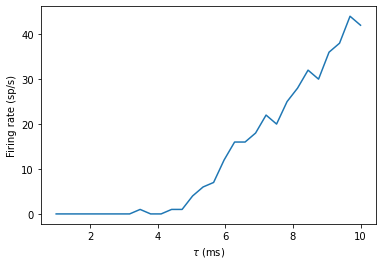

In [4]:
# Copy/restore the state of the network
start_scope()

num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms # Range of the membrane time constant
output_rates = []

P = PoissonGroup(num_inputs, rates=input_rate) # Poisson spiking neurons (source)
eqs = 'dv/dt = -v/tau : 1'
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact') # LIF neuron (target)
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
store() # Store the current state of the network

for tau in tau_range:
    restore()
    run(1*second)
    output_rates.append(M.num_spikes/second)

plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)')

Text(0, 0.5, 'Firing rate (sp/s)')

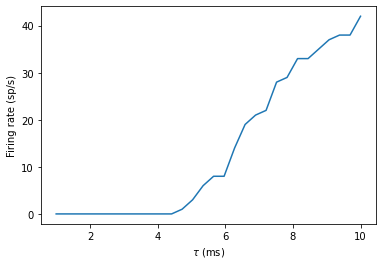

In [9]:
# Run Poisson once so spikes are the same each time
start_scope()

num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms # Range of the membrane time constant
output_rates = []

P = PoissonGroup(num_inputs, rates=input_rate) # Poisson spiking neurons (source)
MP = SpikeMonitor(P)
net = Network(P, MP)
net.run(1*second) # Run and store Poisson spikes
spikes_i = MP.i
spikes_t = MP.t
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)

eqs = 'dv/dt = -v/tau : 1'
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact') # LIF neuron (target)
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)

net = Network(SGG, G, S, M)
net.store() # Store the current state of the network

for tau in tau_range:
    net.restore()
    net.run(1*second)
    output_rates.append(M.num_spikes/second)

plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)')

WARNING    "tau" is an internal variable of group "neurongroup_2", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Text(0, 0.5, 'Firing rate (sp/s)')

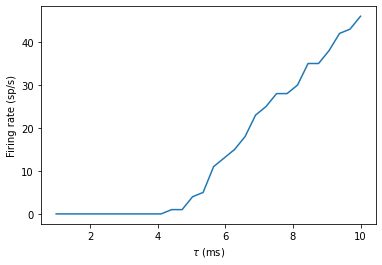

In [10]:
# Run simulation on multiple instances of the same neuron
start_scope()

num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms # Range of the membrane time constant
num_tau = len(tau_range)

P = PoissonGroup(num_inputs, rates=input_rate) # Poisson spiking neurons (source)
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
run(1*second)
output_rates = M.count/second # Firing rate

plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)')

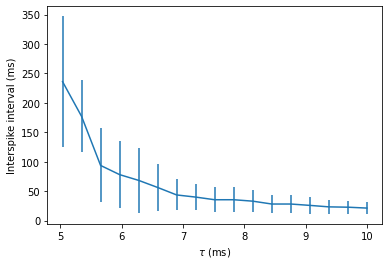

In [11]:
# Mean and standard deviation of the interspike intervals
trains = M.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

Text(0, 0.5, 'v (mV)')

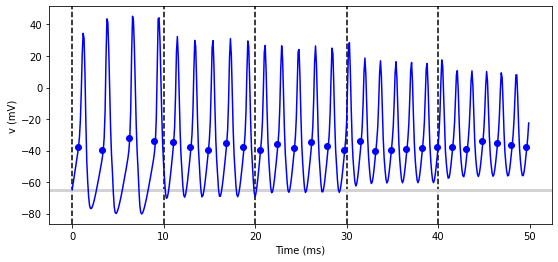

In [18]:
# Inject current into Hodgkin-Huxley type neuron
# Change the amplitude randomly every 10 ms
start_scope()

area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH, threshold='v > -40*mV', refractory='v > -40*mV', method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')

figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA # Change the amplitude randomly
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)    
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)')


Text(0, 0.5, 'v (mV)')

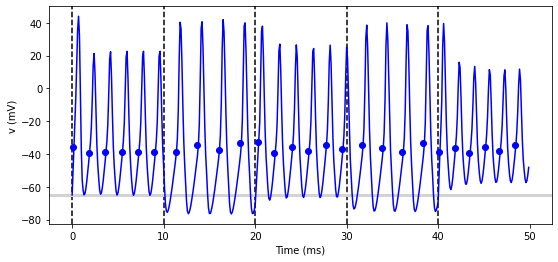

In [19]:
# Run "regularly" instead of multiple runs
start_scope()
group = NeuronGroup(1, eqs_HH, threshold='v > -40*mV', refractory='v > -40*mV', method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
# we keep the loop just to draw the vertical lines
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)')

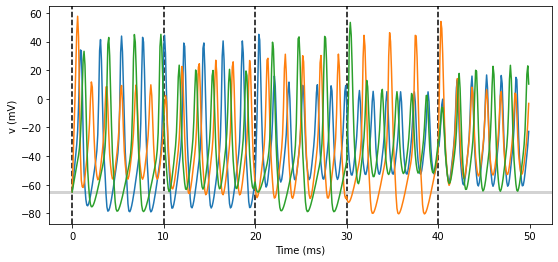

In [26]:
# Run on multiple neurons with different capacitance
start_scope()

N = 3
eqs_HH_2 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
C : farad
'''
group = NeuronGroup(N, eqs_HH_2,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
# initialise with some different capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, variables=True, record=True)
# we go back to run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)');

Text(0, 0.5, 'I (nA)')

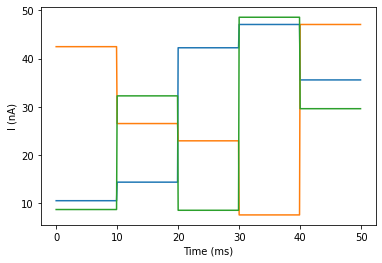

In [27]:
# Injected currents (different for each neuron)
plot(statemon.t/ms, statemon.I.T/nA, '-')
xlabel('Time (ms)')
ylabel('I (nA)')

Text(0, 0.5, 'v (mV)')

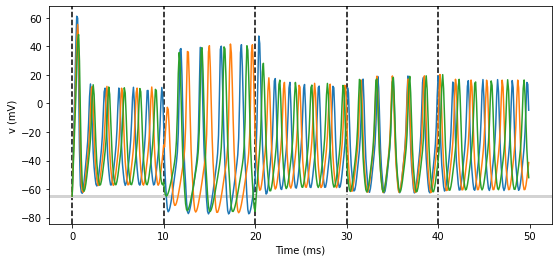

In [28]:
# Inject same current in each neuron
start_scope()
N = 3
eqs_HH_3 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp (shared) # everything is the same except we've added this shared
C : farad
'''
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)')

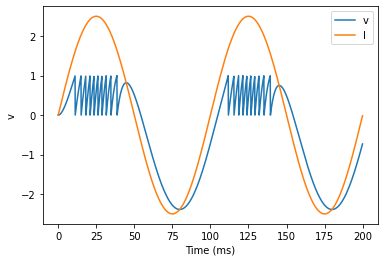

In [35]:
# Inject sinusoidal current in leaky integrate-and-fire neuron
start_scope()

A = 2.5
f = 10*Hz
tau = 5*ms
eqs = '''
dv/dt = (I-v)/tau : 1
I = A*sin(2*pi*f*t) : 1
'''

G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)

plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

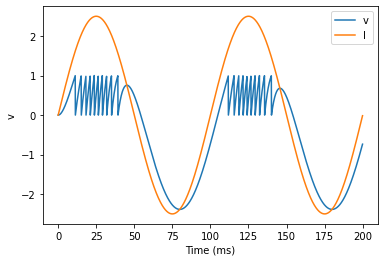

In [42]:
# Inject pre-recorded sinusoidal current in leaky integrate-and-fire neuron
start_scope()

A = 2.5
f = 10*Hz
tau = 5*ms
t_recorded = arange(int(200*ms/defaultclock.dt))*defaultclock.dt
I_recorded = TimedArray(A*sin(2*pi*f*t_recorded), dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''

G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)

plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best')

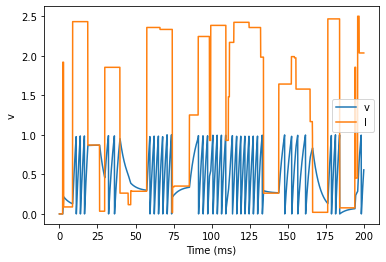

In [48]:
# Arbitrary current
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms

num_samples = int(200*ms/defaultclock.dt)
I_arr = zeros(num_samples)
for _ in range(100):
    a = randint(num_samples)
    I_arr[a:a+100] = rand()
I_recorded = TimedArray(A*I_arr, dt=defaultclock.dt)

eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

Text(0, 0.5, 'Neuron index')

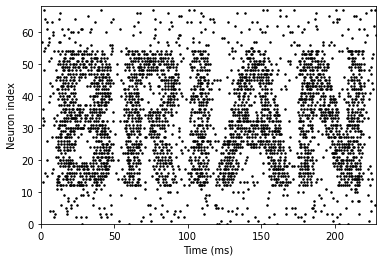

In [111]:
start_scope()

from matplotlib.image import imread
# Read (M, N, 4) RGBA image, change values from 0-1 to 1-0
# Flip horizontally, extract one color, transpose
# Black dots will fire a spike
img = (1-imread('brian.png'))[::-1, :, 0].T
num_samples, N = img.shape # 228, 68
ta = TimedArray(img, dt=1*ms)
A = 1.5
tau = 2*ms
# dv/dt = (A.ta(t) - v(t)) / tau + some white noise (xi)
eqs = '''
dv/dt = (A*ta(t, i)-v)/tau+0.8*xi*tau**-0.5 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='euler')
M = SpikeMonitor(G)
run(num_samples*ms)

plot(M.t/ms, M.i, '.k', ms=3) # Plot spikes of neuron 0 on line 0 etc.
xlim(0, num_samples)
ylim(0, N)
xlabel('Time (ms)')
ylabel('Neuron index')